## Install necessary libraries


In [18]:
%pip install boto3 pandas

## Load data from S3 and EDA

Load the CSV file from the S3 bucket into a pandas DataFrame.

In [19]:
import boto3
import pandas as pd

# Define the S3 bucket and object key
bucket_name = 'genmab-test'
object_key = 'customer_segmentation_data.csv'

session = boto3.Session(
    aws_access_key_id='needed_if_running_outside_aws',
    aws_secret_access_key='needed_if_running_outside_aws',
    region_name='us-east-1'
)

# Create an S3 client
s3 = session.client('s3')

# Get the object from S3
obj = s3.get_object(Bucket='genmab-test', Key=object_key)

# Read the CSV data into a pandas DataFrame
df = pd.read_csv(obj['Body'])

# Display the first few rows of the DataFrame
display(df.head())

,Customer_ID,Age,Income,Purchases,Gender
0,1,26,50640,35,Male
1,2,18,61969,22,Male
2,3,43,89262,2,Female
3,4,60,105248,21,Male
4,5,23,53550,49,Male


In [20]:
# Display the first few rows of the DataFrame
display(df.head())

# Get information about the DataFrame (data types, non-null values)
display(df.info())

# Get descriptive statistics of the numerical columns
display(df.describe())


,Customer_ID,Age,Income,Purchases,Gender
0,1,26,50640,35,Male
1,2,18,61969,22,Male
2,3,43,89262,2,Female
3,4,60,105248,21,Male
4,5,23,53550,49,Male


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Customer_ID  1000 non-null   int64 
 1   Age          1000 non-null   int64 
 2   Income       1000 non-null   int64 
 3   Purchases    1000 non-null   int64 
 4   Gender       1000 non-null   object
dtypes: int64(4), object(1)
memory usage: 39.2+ KB


None

,Customer_ID,Age,Income,Purchases
count,1000.000000,1000.000000,1000.00000,1000.000000
mean,500.500000,43.300000,89852.63900,25.162000
std,288.819436,15.184155,34592.86942,14.503313
min,1.000000,18.000000,30420.00000,0.000000
25%,250.750000,30.000000,61865.75000,13.000000
50%,500.500000,43.000000,89055.50000,25.000000
75%,750.250000,57.000000,117652.00000,38.000000
max,1000.000000,69.000000,149813.00000,49.000000



Visualize histogram, count plot,

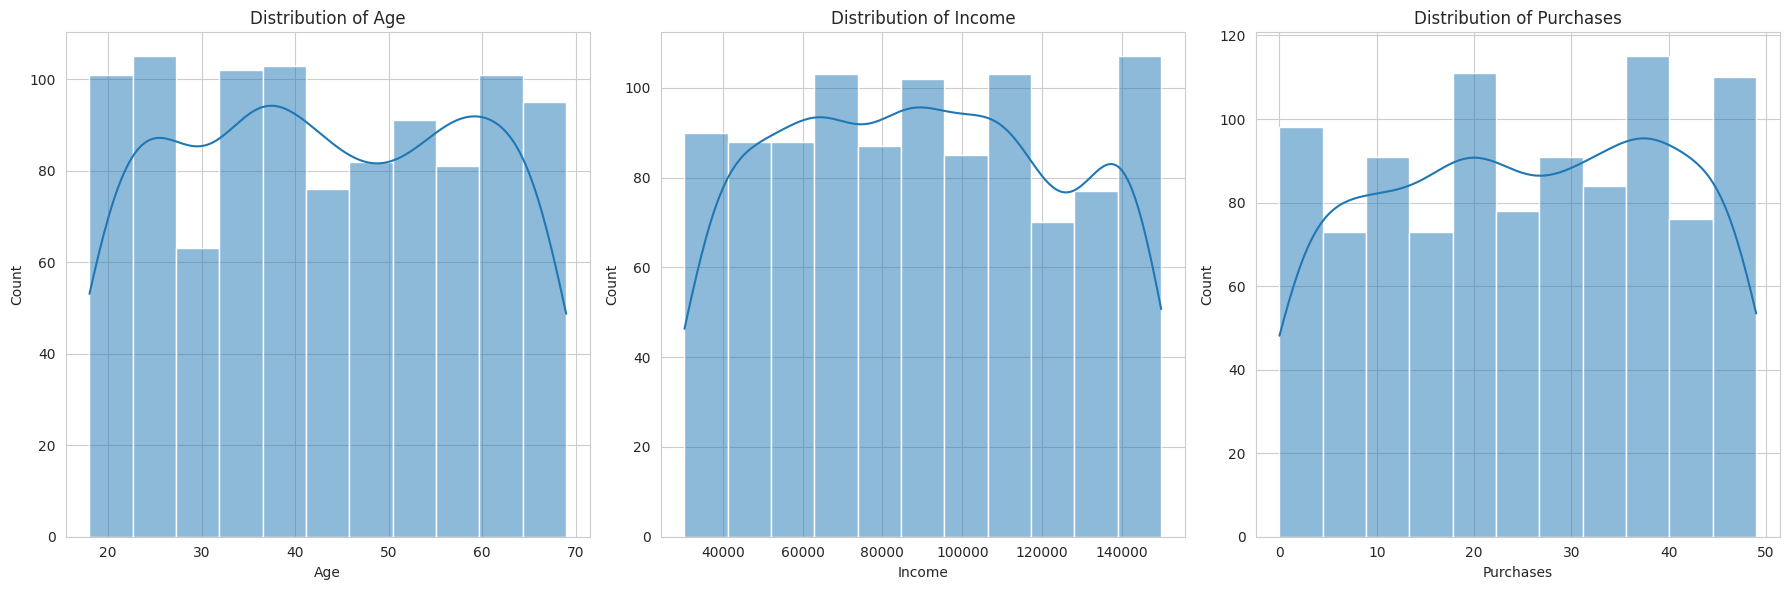

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set_style('whitegrid')

# Create histograms for numerical features
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(data=df, x='Age', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Age')

sns.histplot(data=df, x='Income', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Income')

sns.histplot(data=df, x='Purchases', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Purchases')

plt.tight_layout()
plt.show()

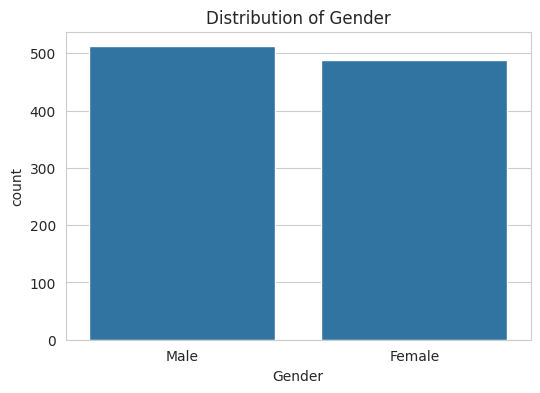

In [22]:
# Create a count plot for the 'Gender' column
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='Gender')
plt.title('Distribution of Gender')
plt.show()

## Preprocessing - feature selection

Select the relevant numerical features for clustering.


In [23]:
import pandas as pd
import numpy as np

def calculate_derived_features(df):
    """
    Calculate specific derived features for customer segmentation.

    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame with columns: Customer_ID, Age, Income, Purchases, Gender

    Returns:
    --------
    pandas.DataFrame
        DataFrame with original columns plus derived features
    """

    # Create a copy
    df_derived = df.copy()


    ###  AGE-BASED DERIVED FEATURES ##

    # Age binary indicators
    df_derived['Is_Young_Adult'] = (df_derived['Age'] <= 30).astype(int)
    df_derived['Is_Middle_Aged'] = ((df_derived['Age'] > 30) & (df_derived['Age'] <= 50)).astype(int)
    df_derived['Is_Senior'] = (df_derived['Age'] > 50).astype(int)

    ### GENDER-BASED DERIVED FEATURES

    # IS_MALE: Binary encoding (1 for Male, 0 for Female)
    df_derived['IS_MALE'] = (df_derived['Gender'] == 'Male').astype(int)



    ### INCOME-BASED DERIVED FEATURES

    income_quartile_temp = pd.qcut(
        df_derived['Income'],
        q=4,
        labels=['Q1_Low', 'Q2_Medium_Low', 'Q3_Medium_High', 'Q4_High']
    )

    # One-hot encode Income_Quartile (drop_first=True to avoid multicollinearity)
    income_quartile_dummies = pd.get_dummies(income_quartile_temp, prefix='Income_Quartile', drop_first=True, dtype=int)
    df_derived = pd.concat([df_derived, income_quartile_dummies], axis=1)

    # Income_Age_Ratio: Income divided by age
    df_derived['Income_Age_Ratio'] = df_derived['Income'] / df_derived['Age']

    ### PURCHASE-BASED DERIVED FEATURES ###

    # Purchase_Quartile: One-hot encoded purchase quartiles
    purchase_quartile_temp = pd.qcut(
        df_derived['Purchases'],
        q=4,
        labels=['Q1_Low', 'Q2_Medium_Low', 'Q3_Medium_High', 'Q4_High']
    )

    # One-hot encode Purchase_Quartile (drop_first=True to avoid multicollinearity)
    purchase_quartile_dummies = pd.get_dummies(purchase_quartile_temp, prefix='Purchase_Quartile', drop_first=True, dtype=int)
    df_derived = pd.concat([df_derived, purchase_quartile_dummies], axis=1)

    # Purchase_Intensity: Normalized purchase frequency (0-1 scale)
    max_purchases = df_derived['Purchases'].max()
    df_derived['Purchase_Intensity'] = df_derived['Purchases'] / max_purchases

    # INTERACTION/RATIO FEATURES

    # Age_Income_Ratio: Age divided by income (in thousands)
    df_derived['Age_Income_Ratio'] = df_derived['Age'] / (df_derived['Income'] / 1000)

    # Purchase_Age_Ratio: Purchases divided by age
    df_derived['Purchase_Age_Ratio'] = df_derived['Purchases'] / df_derived['Age']

    # GENDER-RELATIVE FEATURES

    # Calculate gender-specific averages
    male_avg_income = df_derived[df_derived['Gender'] == 'Male']['Income'].mean()
    female_avg_income = df_derived[df_derived['Gender'] == 'Female']['Income'].mean()

    male_avg_purchases = df_derived[df_derived['Gender'] == 'Male']['Purchases'].mean()
    female_avg_purchases = df_derived[df_derived['Gender'] == 'Female']['Purchases'].mean()

    # Income_Relative_To_Gender_Avg: Income relative to same-gender average
    df_derived['Income_Relative_To_Gender_Avg'] = np.where(
        df_derived['Gender'] == 'Male',
        df_derived['Income'] / male_avg_income,
        df_derived['Income'] / female_avg_income
    )

    # Purchases_Relative_To_Gender_Avg: Purchases relative to same-gender average
    df_derived['Purchases_Relative_To_Gender_Avg'] = np.where(
        df_derived['Gender'] == 'Male',
        df_derived['Purchases'] / male_avg_purchases,
        df_derived['Purchases'] / female_avg_purchases
    )

    df_derived = df_derived.drop(['Gender','Customer_ID'], axis=1)
    return df_derived

In [24]:
df_derived = calculate_derived_features(df)
display(df_derived.head())
display(df_derived.describe())


,Age,Income,Purchases,Is_Young_Adult,Is_Middle_Aged,Is_Senior,IS_MALE,Income_Quartile_Q2_Medium_Low,Income_Quartile_Q3_Medium_High,Income_Quartile_Q4_High,Income_Age_Ratio,Purchase_Quartile_Q2_Medium_Low,Purchase_Quartile_Q3_Medium_High,Purchase_Quartile_Q4_High,Purchase_Intensity,Age_Income_Ratio,Purchase_Age_Ratio,Income_Relative_To_Gender_Avg,Purchases_Relative_To_Gender_Avg
0,26,50640,35,1,0,0,1,0,0,0,1947.692308,0,1,0,0.714286,0.513428,1.346154,0.562491,1.353986
1,18,61969,22,1,0,0,1,1,0,0,3442.722222,1,0,0,0.448980,0.290468,1.222222,0.688330,0.851077
2,43,89262,2,0,1,0,0,0,1,0,2075.860465,0,0,0,0.040816,0.481728,0.046512,0.995466,0.081831
3,60,105248,21,0,0,1,1,0,1,0,1754.133333,1,0,0,0.428571,0.570082,0.350000,1.169058,0.812391
4,23,53550,49,1,0,0,1,0,0,0,2328.260870,0,0,1,1.000000,0.429505,2.130435,0.594815,1.895580


,Age,Income,Purchases,Is_Young_Adult,Is_Middle_Aged,Is_Senior,IS_MALE,Income_Quartile_Q2_Medium_Low,Income_Quartile_Q3_Medium_High,Income_Quartile_Q4_High,Income_Age_Ratio,Purchase_Quartile_Q2_Medium_Low,Purchase_Quartile_Q3_Medium_High,Purchase_Quartile_Q4_High,Purchase_Intensity,Age_Income_Ratio,Purchase_Age_Ratio,Income_Relative_To_Gender_Avg,Purchases_Relative_To_Gender_Avg
count,1000.000000,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,43.300000,89852.63900,25.162000,0.255000,0.377000,0.368000,0.512000,0.250000,0.250000,0.250000,2421.057914,0.242000,0.269000,0.227000,0.513510,0.584891,0.682532,1.000000,1.000000
std,15.184155,34592.86942,14.503313,0.436079,0.484877,0.482503,0.500106,0.433229,0.433229,0.433229,1448.100659,0.428509,0.443662,0.419102,0.295986,0.369864,0.518254,0.385000,0.576687
min,18.000000,30420.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,478.015385,0.000000,0.000000,0.000000,0.000000,0.122238,0.000000,0.337895,0.000000
25%,30.000000,61865.75000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1358.973684,0.000000,0.000000,0.000000,0.265306,0.322238,0.280938,0.687469,0.502909
50%,43.000000,89055.50000,25.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2097.311005,0.000000,0.000000,0.000000,0.510204,0.476801,0.588294,0.992448,1.005818
75%,57.000000,117652.00000,38.000000,1.000000,1.000000,1.000000,1.000000,0.250000,0.250000,0.250000,3103.297454,0.000000,1.000000,0.000000,0.775510,0.735861,0.958750,1.308598,1.508727
max,69.000000,149813.00000,49.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,8180.777778,1.000000,1.000000,1.000000,1.000000,2.091983,2.722222,1.668600,2.004863


Box plot of numerical features to check for outliers.

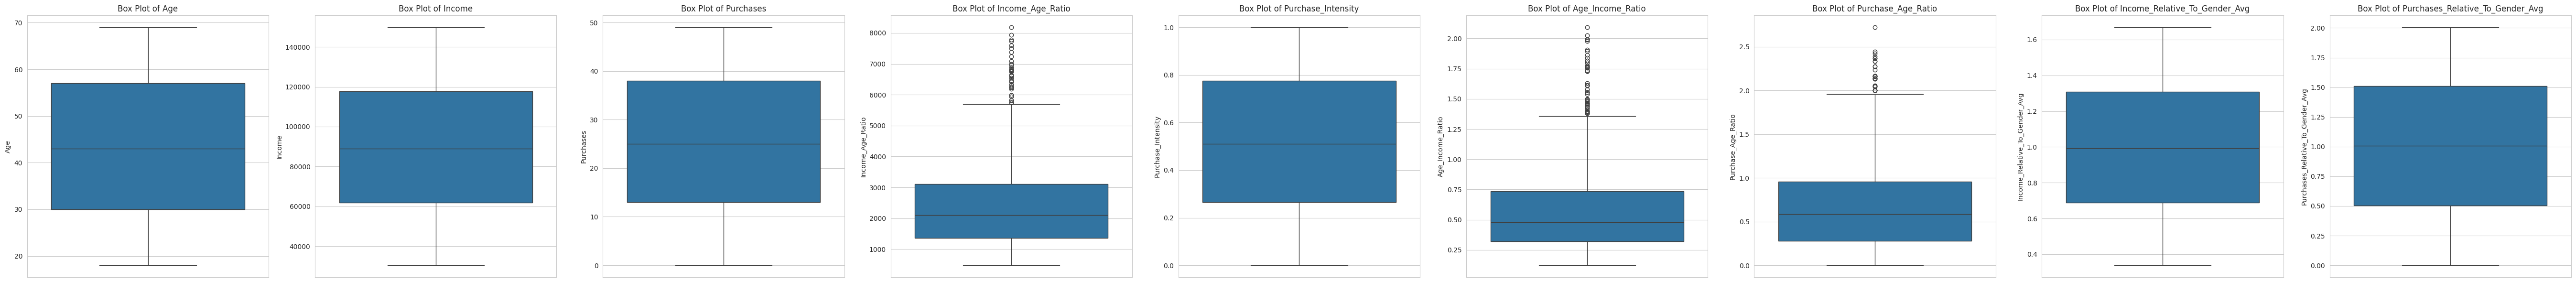

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Select the numerical features for boxplot
numerical_features = ['Age', 'Income', 'Purchases', 'Income_Age_Ratio', 'Purchase_Intensity','Age_Income_Ratio','Purchase_Age_Ratio','Income_Relative_To_Gender_Avg','Purchases_Relative_To_Gender_Avg']

# Create box plots for numerical features
fig, axes = plt.subplots(1, len(numerical_features), figsize=(6 * len(numerical_features), 6))

# Adjust for the case of a single numerical feature
if len(numerical_features) == 1:
    axes = [axes]

for i, feature in enumerate(numerical_features):
    sns.boxplot(y=df_derived[feature], ax=axes[i])
    axes[i].set_title(f'Box Plot of {feature}')
    axes[i].set_ylabel(feature)

plt.tight_layout()
plt.show()

## Preprocessing - explore different scaling methods

Apply different scaling techniques (e.g., StandardScaler, MinMaxScaler) to the selected features and compare their effects.


In [26]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, Normalizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# List of scalers
scalers = [StandardScaler(), RobustScaler(), MinMaxScaler(), Normalizer()]

# Function to apply KMeans and return evaluation metrics

def evaluate_clustering(processed_df, n_clusters_list, scaler, n_components_list):
    results = []
    for n_components in n_components_list:
        pca = PCA(n_components=n_components)
        pca_features = pca.fit_transform(processed_df)
        for n_clusters in n_clusters_list:
            kmeans = KMeans(n_clusters=n_clusters, init='k-means++', n_init=20, max_iter=300, random_state=42)
            cluster_labels = kmeans.fit_predict(pca_features)
            silhouette_avg = silhouette_score(pca_features, cluster_labels)
            calinski_harabasz = calinski_harabasz_score(pca_features, cluster_labels)
            davies_bouldin = davies_bouldin_score(pca_features, cluster_labels)
            results.append({
                'Scaler': scaler.__class__.__name__,
                'n_clusters': n_clusters,
                'n_components': n_components,
                'Silhouette Score': silhouette_avg,
                'Calinski-Harabasz Index': calinski_harabasz,
                'Davies-Bouldin Index': davies_bouldin
            })
    return results

# All experiment results
all_results = []

# Separate continuous and binary features
df_continuous = df_derived[numerical_features]

# Get non-continuous features as ones that are not numerical_features

df_non_numerical_feature = df_derived.drop(numerical_features, axis=1)

display(df_continuous.head())
display(df_non_numerical_feature.head())

for scaler in scalers:
    # Scale only the continuous features
    scaled_continuous_features = scaler.fit_transform(df_continuous)
    scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=numerical_features)

    # Concatenate scaled continuous features with the original Gender_Male column
    processed_df = pd.concat([scaled_continuous_df, df_non_numerical_feature.reset_index(drop=True)], axis=1)

    # Define the range of clusters to test
    n_components_list = range(1, 5)
    n_clusters_list = range(2, 11)

    # Evaluate clustering for each scaler and KMeans configuration with mixed features
    results = evaluate_clustering(processed_df, n_clusters_list, scaler, n_components_list)
    all_results.extend(results)

# Display the results
all_results = pd.DataFrame(all_results)
display(all_results)

,Age,Income,Purchases,Income_Age_Ratio,Purchase_Intensity,Age_Income_Ratio,Purchase_Age_Ratio,Income_Relative_To_Gender_Avg,Purchases_Relative_To_Gender_Avg
0,26,50640,35,1947.692308,0.714286,0.513428,1.346154,0.562491,1.353986
1,18,61969,22,3442.722222,0.448980,0.290468,1.222222,0.688330,0.851077
2,43,89262,2,2075.860465,0.040816,0.481728,0.046512,0.995466,0.081831
3,60,105248,21,1754.133333,0.428571,0.570082,0.350000,1.169058,0.812391
4,23,53550,49,2328.260870,1.000000,0.429505,2.130435,0.594815,1.895580


,Is_Young_Adult,Is_Middle_Aged,Is_Senior,IS_MALE,Income_Quartile_Q2_Medium_Low,Income_Quartile_Q3_Medium_High,Income_Quartile_Q4_High,Purchase_Quartile_Q2_Medium_Low,Purchase_Quartile_Q3_Medium_High,Purchase_Quartile_Q4_High
0,1,0,0,1,0,0,0,0,1,0
1,1,0,0,1,1,0,0,1,0,0
2,0,1,0,0,0,1,0,0,0,0
3,0,0,1,1,0,1,0,1,0,0
4,1,0,0,1,0,0,0,0,0,1


,Scaler,n_clusters,n_components,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
0,StandardScaler,2,1,0.573003,2069.603181,0.576428
1,StandardScaler,3,1,0.539682,2558.957642,0.545073
2,StandardScaler,4,1,0.546545,3144.767443,0.523832
3,StandardScaler,5,1,0.529775,3566.441441,0.542758
4,StandardScaler,6,1,0.538476,4029.401832,0.517578
...,...,...,...,...,...,...
139,Normalizer,6,4,0.365253,485.936621,1.174679
140,Normalizer,7,4,0.378085,494.826682,1.061396
141,Normalizer,8,4,0.393418,540.918106,0.961014
142,Normalizer,9,4,0.404726,544.730584,0.900614


In [27]:
# Sort by Silhouette Score (highest to lowest)
print("results_df_mixed_features sorted by Silhouette Score (highest to lowest):")
display(all_results.sort_values(by='Silhouette Score', ascending=False))

# Sort by Calinski-Harabasz Index (highest to lowest)
print("\nresults_df_mixed_features sorted by Calinski-Harabasz Index (highest to lowest):")
display(all_results.sort_values(by='Calinski-Harabasz Index', ascending=False))

# Sort by Davies-Bouldin Index (lowest to highest)
print("\nresults_df_mixed_features sorted by Davies-Bouldin Index (lowest to highest):")
display(all_results.sort_values(by='Davies-Bouldin Index', ascending=True))

results_df_mixed_features sorted by Silhouette Score (highest to lowest):


,Scaler,n_clusters,n_components,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
109,Normalizer,3,1,0.915170,70591.932986,0.118954
110,Normalizer,4,1,0.789262,62480.134991,0.352630
118,Normalizer,3,2,0.780009,5342.377697,0.311131
108,Normalizer,2,1,0.746573,4098.966583,0.328329
119,Normalizer,4,2,0.692431,4838.939103,0.474873
...,...,...,...,...,...,...
65,RobustScaler,4,4,0.270374,402.973697,1.240417
66,RobustScaler,5,4,0.267740,397.941895,1.211300
64,RobustScaler,3,4,0.266759,431.100411,1.285675
29,StandardScaler,4,4,0.265705,439.308284,1.207638



results_df_mixed_features sorted by Calinski-Harabasz Index (highest to lowest):


,Scaler,n_clusters,n_components,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
116,Normalizer,10,1,0.596996,125052.279748,0.506752
115,Normalizer,9,1,0.596209,119487.999269,0.516224
114,Normalizer,8,1,0.591128,101724.346763,0.535520
113,Normalizer,7,1,0.583684,88662.149813,0.564665
112,Normalizer,6,1,0.565761,82672.834054,0.607290
...,...,...,...,...,...,...
34,StandardScaler,9,4,0.284861,390.193274,1.143954
68,RobustScaler,7,4,0.287071,390.070459,1.100829
67,RobustScaler,6,4,0.271328,389.822830,1.140442
35,StandardScaler,10,4,0.287208,383.493493,1.164967



results_df_mixed_features sorted by Davies-Bouldin Index (lowest to highest):


,Scaler,n_clusters,n_components,Silhouette Score,Calinski-Harabasz Index,Davies-Bouldin Index
109,Normalizer,3,1,0.915170,70591.932986,0.118954
118,Normalizer,3,2,0.780009,5342.377697,0.311131
108,Normalizer,2,1,0.746573,4098.966583,0.328329
110,Normalizer,4,1,0.789262,62480.134991,0.352630
119,Normalizer,4,2,0.692431,4838.939103,0.474873
...,...,...,...,...,...,...
135,Normalizer,2,4,0.319313,423.660205,1.364678
18,StandardScaler,2,3,0.295820,464.761114,1.372411
27,StandardScaler,2,4,0.282435,436.281365,1.432276
99,MinMaxScaler,2,4,0.304295,382.537292,1.451345


## Apply normalizer and k-means with 3 clusters (Best Combination)

Apply the Normalizer scaler to the selected features and then perform K-Means clustering with n_clusters=3 and n_components=1 as it yielded in best Silhouette Score and	Calinski-Harabasz Index


In [28]:
from sklearn.preprocessing import Normalizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Instantiate Normalizer
normalizer = Normalizer()

# Scale only the continuous features
scaled_continuous_features = normalizer.fit_transform(df_continuous)
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=numerical_features)

# Concatenate scaled continuous features with the original Gender_Male column
processed_df = pd.concat([scaled_continuous_df, df_non_numerical_feature.reset_index(drop=True)], axis=1)


# Apply PCA with 1 component
pca = PCA(n_components=1)
pca_features = pca.fit_transform(processed_df)

# Instantiate KMeans with 3 clusters
kmeans_3_clusters = KMeans(n_clusters=3, init='k-means++', n_init=20, max_iter=300, random_state=42)

# Fit KMeans to the PCA transformed data and get cluster labels
cluster_labels_optimal = kmeans_3_clusters.fit_predict(pca_features)

## Analyze and interpret clusters

Analyze the characteristics of the 3 clusters using visualizations, and interpret the results to define meaningful customer segments.


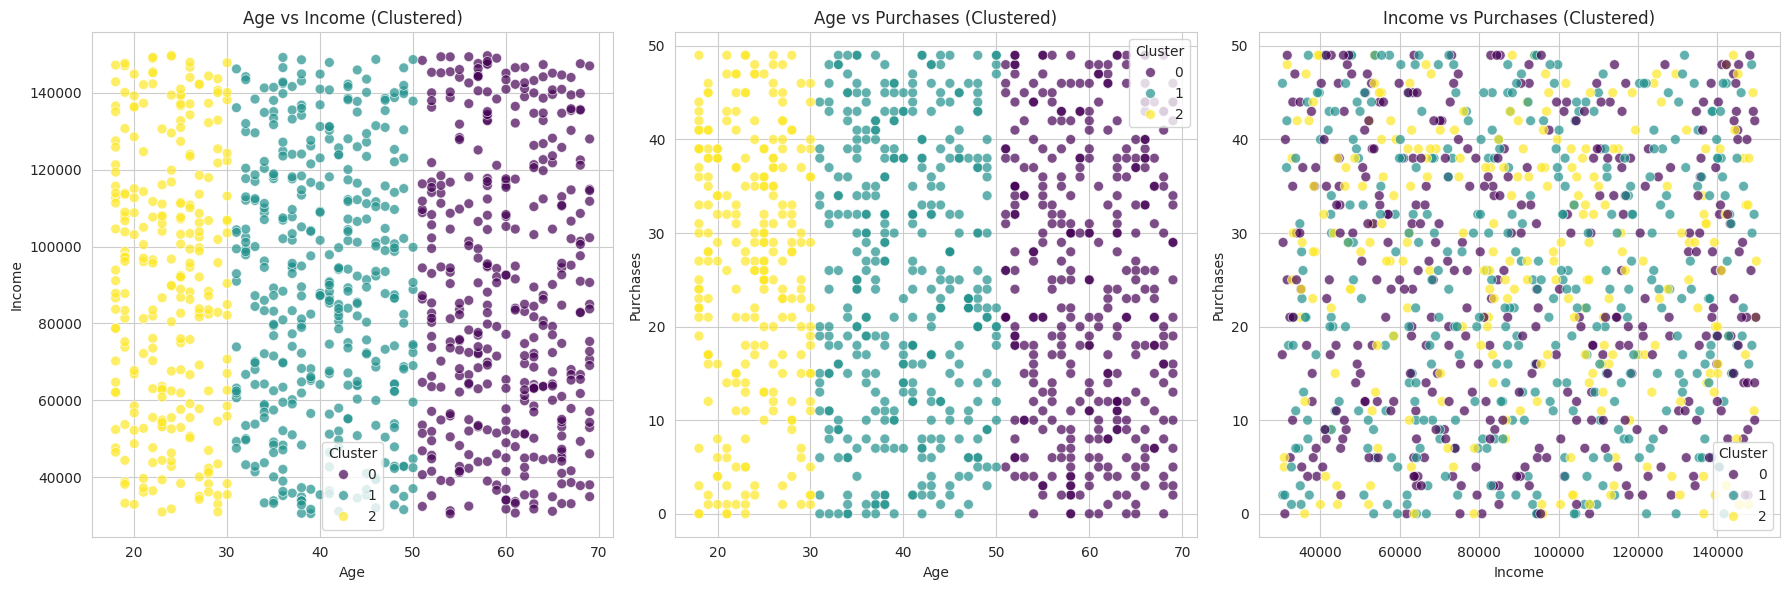

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

# Add the cluster labels to the original DataFrame for visualization
# Assuming 'df' is your original DataFrame and 'cluster_labels_optimal' contains the cluster assignments
# If you used a different variable for the final cluster labels, please adjust the line below
df_viz = df.copy()
df_viz['Cluster_Label_Optimal'] = cluster_labels_optimal

# Define the pairs of original numerical features for scatter plots
feature_pairs = [('Age', 'Income'), ('Age', 'Purchases'), ('Income', 'Purchases')]

# Create scatter plots for each feature pair, colored by cluster label
fig, axes = plt.subplots(nrows=1, ncols=len(feature_pairs), figsize=(6 * len(feature_pairs), 6))
axes = axes.flatten() # Flatten in case of a single subplot

for i, (x_feature, y_feature) in enumerate(feature_pairs):
    sns.scatterplot(data=df_viz, x=x_feature, y=y_feature, hue='Cluster_Label_Optimal', ax=axes[i], palette='viridis', s=50, alpha=0.7)
    axes[i].set_title(f'{x_feature} vs {y_feature} (Clustered)')
    axes[i].set_xlabel(x_feature)
    axes[i].set_ylabel(y_feature)
    axes[i].legend(title='Cluster')

plt.tight_layout()
plt.show()

## Define Cluster Names

Assign meaningful names to each of the 3 clusters based on the analysis. Based scatter plot we can clearly see 3 clusters and they are based on age.

In [30]:
# Based on the cluster analysis above, define meaningful names for each cluster.
# Replace 'Cluster X Name' with your interpretation.
cluster_names_optimal = {
    0: 'Old',
    1: 'Middle Aged',
    2: 'Young'
}

print("Defined Cluster Names:")
for cluster_label, name in cluster_names_optimal.items():
    print(f"Cluster {cluster_label}: {name}")

Defined Cluster Names:
Cluster 0: Old
Cluster 1: Middle Aged
Cluster 2: Young


## Prepare for Inference - Save Models

Save the trained Normalizer scaler, PCA model, and K-Means model for later use in predicting clusters for new data.

In [31]:
import joblib

# Define filenames for saving the models
normalizer_filename = 'normalizer_scaler.pkl'
pca_filename = 'pca_model.pkl'
kmeans_filename = 'kmeans_model_optimal.pkl'

# Save the trained Normalizer scaler, PCA model, and KMeans model
joblib.dump(normalizer, normalizer_filename)
joblib.dump(pca, pca_filename)
joblib.dump(kmeans_3_clusters, kmeans_filename)

print(f"Normalizer scaler saved to {normalizer_filename}")
print(f"PCA model saved to {pca_filename}")
print(f"KMeans model saved to {kmeans_filename}")

Normalizer scaler saved to normalizer_scaler.pkl
PCA model saved to pca_model.pkl
KMeans model saved to kmeans_model_optimal.pkl


## Load Models for Inference

Load the saved scaler, PCA model, and K-Means model.

In [32]:
import joblib
import pandas as pd

# Define filenames for loading the models
normalizer_filename = 'normalizer_scaler.pkl'
pca_filename = 'pca_model.pkl'
kmeans_filename = 'kmeans_model_optimal.pkl'

# Load the saved Normalizer scaler, PCA model, and KMeans model
loaded_normalizer = joblib.load(normalizer_filename)
loaded_pca_model = joblib.load(pca_filename)
loaded_kmeans_model = joblib.load(kmeans_filename)

print("Scaler, PCA model, and KMeans model loaded successfully.")

Scaler, PCA model, and KMeans model loaded successfully.


## Prepare New Data for Inference

Create and preprocess a sample DataFrame for new, unseen customer data, applying the same steps (including feature engineering and scaling) as the training data.

In [33]:
# Create a sample DataFrame for new, unseen customer data
# This data should have the same original columns as your training data
new_customer_data = pd.DataFrame({
    'Customer_ID': [1001, 1002, 1003, 1004],
    'Age': [30, 55, 22, 40],
    'Income': [75000, 40000, 120000, 10000],
    'Purchases': [15, 30, 5, 1],
    'Gender': ['Male', 'Female', 'Female', 'Male']
})

print("New customer data:")
display(new_customer_data)

# --- Preprocessing for Inference ---
# This follows the same preprocessing steps as the training data

new_data_derived = calculate_derived_features(new_customer_data.copy())

# Separate continuous and binary features
df_continuous = new_data_derived[numerical_features]
# Get non-continuous features as ones that are not numerical_features
df_non_numerical_feature = new_data_derived.drop(numerical_features, axis=1)


# Scale only the continuous features
scaled_continuous_features = loaded_normalizer.transform(df_continuous)
scaled_continuous_df = pd.DataFrame(scaled_continuous_features, columns=numerical_features)

# Concatenate scaled continuous features with the original Gender_Male column
processed_df = pd.concat([scaled_continuous_df, df_non_numerical_feature.reset_index(drop=True)], axis=1)

display(processed_df)

# Apply PCA with 1 component
pca = loaded_pca_model
pca_features = pca.transform(processed_df)

cluster_labels_optimal = loaded_kmeans_model.predict(pca_features)

# Add the predicted cluster labels back to the original new customer data DataFrame
new_customer_data['Predicted_Cluster_Label'] = cluster_labels_optimal

print("\nNew customer data with predicted cluster labels:")
display(new_customer_data)


new_customer_data['Predicted_Segment'] = new_customer_data['Predicted_Cluster_Label'].map(cluster_names_optimal)

print("\nNew customer data with predicted segments:")
display(new_customer_data)


New customer data:


,Customer_ID,Age,Income,Purchases,Gender
0,1001,30,75000,15,Male
1,1002,55,40000,30,Female
2,1003,22,120000,5,Female
3,1004,40,10000,1,Male


,Age,Income,Purchases,Income_Age_Ratio,Purchase_Intensity,Age_Income_Ratio,Purchase_Age_Ratio,Income_Relative_To_Gender_Avg,Purchases_Relative_To_Gender_Avg,Is_Young_Adult,Is_Middle_Aged,Is_Senior,IS_MALE,Income_Quartile_Q2_Medium_Low,Income_Quartile_Q3_Medium_High,Income_Quartile_Q4_High,Purchase_Quartile_Q2_Medium_Low,Purchase_Quartile_Q3_Medium_High,Purchase_Quartile_Q4_High
0,0.000400,0.999445,0.000200,0.033315,0.000007,0.000005,0.000007,0.000024,0.000025,1,0,0,1,0,1,0,0,1,0
1,0.001375,0.999834,0.000750,0.018179,0.000025,0.000034,0.000014,0.000012,0.000043,0,0,1,0,1,0,0,0,0,1
2,0.000183,0.998969,0.000042,0.045408,0.000001,0.000002,0.000002,0.000012,0.000002,1,0,0,0,0,0,1,1,0,0
3,0.003999,0.999680,0.000100,0.024992,0.000003,0.000400,0.000002,0.000024,0.000012,0,1,0,1,0,0,0,0,0,0



New customer data with predicted cluster labels:


,Customer_ID,Age,Income,Purchases,Gender,Predicted_Cluster_Label
0,1001,30,75000,15,Male,2
1,1002,55,40000,30,Female,0
2,1003,22,120000,5,Female,2
3,1004,40,10000,1,Male,1



New customer data with predicted segments:


,Customer_ID,Age,Income,Purchases,Gender,Predicted_Cluster_Label,Predicted_Segment
0,1001,30,75000,15,Male,2,Young
1,1002,55,40000,30,Female,0,Old
2,1003,22,120000,5,Female,2,Young
3,1004,40,10000,1,Male,1,Middle Aged
